In [1]:
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import Lasso

from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, save_stabl_results, export_stabl_to_csv
from stabl.preprocessing import LowInfoFilter, remove_low_info_samples

%config InlineBackend.figure_formats=['retina']

In [4]:
from stabl.multi_omic_pipelines import multi_omic_stabl, multi_omic_stabl_cv, late_fusion_lasso_cv
from stabl.single_omic_pipelines import single_omic_stabl, single_omic_stabl_cv
from stabl.pipelines_utils import compute_features_table

# Data

## Mean

In [5]:
Val_Celldensities = pd.read_csv('./DataValidation/Val_celldensities.csv', index_col=0)
Val_Function = pd.read_csv('./DataValidation/Val_functional.csv', index_col=0)
Val_Metavariables = pd.read_csv('./DataValidation/Val_metavariables.csv', index_col=0)
Val_Neighborhood = pd.read_csv('./DataValidation/Val_neighborhood.csv', index_col=0)

val_data = {
    'Celldensities': Val_Celldensities,
    'Function': Val_Function,
    'Metavariables': Val_Metavariables,
    'Neighborhood': Val_Neighborhood
}

for data_name, data_frame in val_data.items():
    numeric_columns = data_frame.select_dtypes(include=['float64', 'int64']).columns
    val_data[data_name][numeric_columns] = val_data[data_name][numeric_columns].apply(zscore)

Val_y = pd.read_csv('./DataValidation/Val_outcome.csv',index_col=0)
Val_y['site'] = 'Stanford'
#Val_y = Val_y.grade-1

In [6]:
UOP_Celldensities = pd.read_csv('./DataTraining/UOPfinal_celldensities.csv', index_col=0)
UOP_Function = pd.read_csv('./DataTraining/UOPfinal_functional.csv', index_col=0)
UOP_Metavariables = pd.read_csv('./DataTraining/UOPfinal_metavariables.csv', index_col=0)
UOP_Neighborhood = pd.read_csv('./DataTraining/UOPfinal_neighborhood.csv', index_col=0)

UOP_data = {
    'Celldensities': UOP_Celldensities,
    'Function': UOP_Function,
    'Metavariables': UOP_Metavariables,
    'Neighborhood': UOP_Neighborhood
}

for data_name, data_frame in UOP_data.items():
    numeric_columns = data_frame.select_dtypes(include=['float64', 'int64']).columns
    UOP_data[data_name][numeric_columns] = UOP_data[data_name][numeric_columns].apply(zscore)

UOP_y = pd.read_csv('./DataTraining/UOPfinal_outcome.csv',index_col=0)
UOP_y['site'] = 'UOP'

In [7]:
X_Celldensities = pd.concat([Val_Celldensities, UOP_Celldensities])
X_Function = pd.concat([Val_Function, UOP_Function])
X_Metavariables = pd.concat([Val_Metavariables, UOP_Metavariables])
X_Neighborhood = pd.concat([Val_Neighborhood, UOP_Neighborhood])
y = pd.concat([Val_y, UOP_y])
y['patient_id'] = y.index.str.split('_').str.get(0)

data = {
    'Celldensities': X_Celldensities,
    'Function': X_Function,
    'Metavariables': X_Metavariables,
    'Neighborhood': X_Neighborhood,
    'Outcome': y
}

In [8]:
print(f"Data from Stanford :\n\t grade 1 : {((y['grade'] == 1) & (y['site'] == 'Stanford')).sum()} \n\t grade 2 : {((y['grade'] == 2) & (y['site'] == 'Stanford')).sum()}")
print(f"Data from UOP :\n\t grade 1 : {((y['grade'] == 1) & (y['site'] == 'UOP')).sum()} \n\t grade 2 : {((y['grade'] == 2) & (y['site'] == 'UOP')).sum()}")
print(f"Total Data :\n\t grade 1 : {((y['grade'] == 1)).sum()} \n\t grade 2 : {((y['grade'] == 2)).sum()} \n\t Total   : {y.shape[0]}")

Data from Stanford :
	 grade 1 : 36 
	 grade 2 : 35
Data from UOP :
	 grade 1 : 39 
	 grade 2 : 32
Total Data :
	 grade 1 : 75 
	 grade 2 : 67 
	 Total   : 142


In [13]:
unique_patients = pd.DataFrame(y['patient_id'].unique(), columns=['patient_id'])
unique_patients = unique_patients.merge(y, on='patient_id', how = 'left') 
unique_patients = unique_patients.drop_duplicates(subset=['patient_id', 'grade', 'site'])
#unique_patients

In [29]:
# Split the dataframe into training and validation sets
train_df, val_df = train_test_split(unique_patients, test_size=0.3, stratify=unique_patients[['site', 'grade']])
#print(train_df)
# Print the shapes of the training and validation sets
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
train_indices = y[y['patient_id'].isin(train_df['patient_id'])].index
test_indices = y[y['patient_id'].isin(val_df['patient_id'])].index
#train_indices

Training set shape: (33, 3)
Validation set shape: (15, 3)


In [30]:
# print(f"Train set")
# print(f"Proportion of UOP : {len(train_df[train_df['site']=='UOP'])/len(train_df)}")
# print(f"Proportion of Stanford : {len(train_df[train_df['site']=='Stanford'])/len(train_df)}")
# print(f"Proportion of grade 1 : {len(train_df[train_df['grade']==1])/len(train_df)}")
# print(f"Proportion of grade 2 : {len(train_df[train_df['grade']==2])/len(train_df)}")
# print()
# print(f"Validation set")
# print(f"Proportion of UOP : {len(val_df[val_df['site']=='UOP'])/len(val_df)}")
# print(f"Proportion of Stanford : {len(val_df[val_df['site']=='Stanford'])/len(val_df)}")
# print(f"Proportion of grade 1 : {len(val_df[val_df['grade']==1])/len(val_df)}")
# print(f"Proportion of grade 2 : {len(val_df[val_df['grade']==2])/len(val_df)}")

In [58]:
# Split each dataframe in the data dictionary into train and test
train_data_dict = {}
test_data_dict = {}

for key, df in data.items():
    train_df = df.loc[train_indices]  # Select rows from the dataframe based on train indices
    test_df = df.loc[test_indices] # Drop rows from the dataframe based on train indices
    
    train_data_dict[key] = train_df
    test_data_dict[key] = test_df


train_outcome = train_data_dict.pop('Outcome')
train_outcome = train_outcome.grade-1 # So that we get values that are 0 and 1 instead of 1 and 2
test_outcome = test_data_dict.pop('Outcome')
test_outcome = test_outcome.grade-1 # So that we get values that are 0 and 1 instead of 1 and 2

## Median

In [59]:
Val_Celldensities_median = pd.read_csv('./DataValidation/Stanford_celldensities_median.csv', index_col=0)
Val_Function_median = pd.read_csv('./DataValidation/Stanford_functional_median.csv', index_col=0)
Val_Metavariables_median = pd.read_csv('./DataValidation/Stanford_metavariables_median.csv', index_col=0)
Val_Neighborhood_median = pd.read_csv('./DataValidation/Stanford_neighborhood_median.csv', index_col=0)

val_data_median = {
    'Celldensities': Val_Celldensities_median,
    'Function': Val_Function_median,
    'Metavariables': Val_Metavariables_median,
    'Neighborhood': Val_Neighborhood_median
}

# for data_name, data_frame in val_data_median.items():
#     numeric_columns = data_frame.select_dtypes(include=['float64', 'int64']).columns
#     val_data_median[data_name][numeric_columns] = val_data_median[data_name][numeric_columns].apply(zscore)

Val_y = pd.read_csv('./DataValidation/Val_outcome.csv',index_col=0)
Val_y['site'] = 'Stanford'
#Val_y = Val_y.grade-1

In [60]:
UOP_Celldensities_median = pd.read_csv('./DataTraining/UOP_celldensities_median.csv', index_col=0)
UOP_Function_median = pd.read_csv('./DataTraining/UOP_functional_median.csv', index_col=0)
UOP_Metavariables_median = pd.read_csv('./DataTraining/UOP_metavariables_median.csv', index_col=0)
UOP_Neighborhood_median = pd.read_csv('./DataTraining/UOP_neighborhood_median.csv', index_col=0)

UOP_data_median = {
    'Celldensities': UOP_Celldensities_median,
    'Function': UOP_Function_median,
    'Metavariables': UOP_Metavariables_median,
    'Neighborhood': UOP_Neighborhood_median
}

# for data_name, data_frame in UOP_data_median.items():
#     numeric_columns = data_frame.select_dtypes(include=['float64', 'int64']).columns
#     UOP_data_median[data_name][numeric_columns] = UOP_data_median[data_name][numeric_columns].apply(zscore)

UOP_y = pd.read_csv('./DataTraining/UOPfinal_outcome.csv',index_col=0)
UOP_y['site'] = 'UOP'

In [61]:
X_Celldensities_median = pd.concat([Val_Celldensities, UOP_Celldensities])
X_Function_median = pd.concat([Val_Function, UOP_Function])
X_Metavariables_median = pd.concat([Val_Metavariables, UOP_Metavariables])
X_Neighborhood_median = pd.concat([Val_Neighborhood, UOP_Neighborhood])
y = pd.concat([Val_y, UOP_y])
y['patient_id'] = y.index.str.split('_').str.get(0)

data_median = {
    'Celldensities': X_Celldensities_median,
    'Function': X_Function_median,
    'Metavariables': X_Metavariables_median,
    'Neighborhood': X_Neighborhood_median,
    'Outcome': y
}

In [62]:
print(f"Data from Stanford :\n\t grade 1 : {((y['grade'] == 1) & (y['site'] == 'Stanford')).sum()} \n\t grade 2 : {((y['grade'] == 2) & (y['site'] == 'Stanford')).sum()}")
print(f"Data from UOP :\n\t grade 1 : {((y['grade'] == 1) & (y['site'] == 'UOP')).sum()} \n\t grade 2 : {((y['grade'] == 2) & (y['site'] == 'UOP')).sum()}")
print(f"Total Data :\n\t grade 1 : {((y['grade'] == 1)).sum()} \n\t grade 2 : {((y['grade'] == 2)).sum()} \n\t Total   : {y.shape[0]}")

Data from Stanford :
	 grade 1 : 36 
	 grade 2 : 35
Data from UOP :
	 grade 1 : 39 
	 grade 2 : 32
Total Data :
	 grade 1 : 75 
	 grade 2 : 67 
	 Total   : 142


# Univariate Analysis

## Mean

In [63]:
global_data = pd.concat([X_Celldensities, X_Function, X_Metavariables, X_Neighborhood], axis=1)
global_outcome = y['grade'] - 1 # instead of 1-2 -> 0-1 for the grade

In [64]:
from scipy.stats import mannwhitneyu
import os
from stabl.visualization import boxplot_features
from pathlib import Path

def univariate_analysis(data_dict, data_dict_name, value_type='mean'):
    resultFolderUnivariate = Path("./Univariate", value_type, data_dict_name)
    os.makedirs(resultFolderUnivariate, exist_ok=True)

    datasets = {'global': pd.concat([data_dict['Celldensities'], data_dict['Function'], data_dict['Metavariables'],data_dict['Neighborhood']], axis=1), 
                'Celldensities' : data_dict['Celldensities'], 
                'Function' : data_dict['Function'], 
                'Metavariables' : data_dict['Metavariables'], 
                'Neighborhood' : data_dict['Neighborhood']
                }
    
    for data_name, dataset in datasets.items():
        
        os.makedirs(Path(resultFolderUnivariate, data_name), exist_ok=True)
        
        vals1 = []
        vals2 = []
        for col in dataset.columns:
            a,b = mannwhitneyu(dataset.loc[global_outcome == 0,col].to_numpy(),dataset.loc[global_outcome == 1,col].to_numpy())
            vals1.append(a)
            vals2.append(b)
                    
        res = pd.DataFrame(data=[vals1,vals2],index= ["Mann-Whitney U-test","p-value"],columns=dataset.columns)
        res = res.sort_values(by="p-value",axis=1)
        res.T.to_csv(Path(resultFolderUnivariate, data_name, "Mann-WhitneyU-testPval.csv"))
                    

        boxplot_features(
            list_of_features=res.columns[:20],
            df_X=dataset[res.columns[:20]],
            y=global_outcome,
            show_fig=False,
            export_file=True,
            path = Path(resultFolderUnivariate, data_name)
        )


In [65]:
univariate_analysis(data, 'Stanford+UOP', value_type='mean without Zscoring')
univariate_analysis(val_data, 'Stanford', value_type='mean without Zscoring')
univariate_analysis(UOP_data, 'UOP',  value_type='mean without Zscoring')

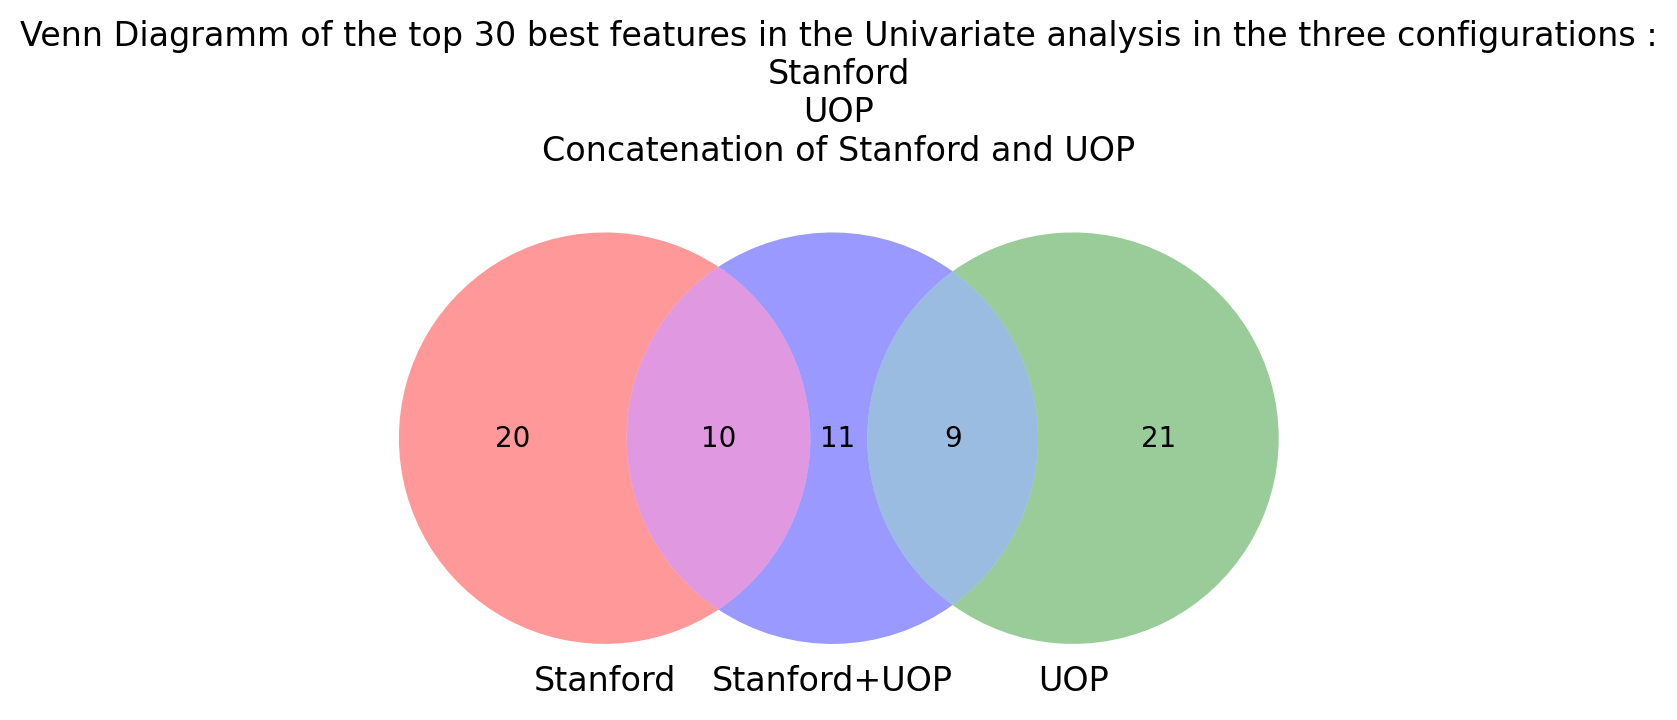

In [66]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
top_features_val = set(pd.read_csv('./Univariate/mean without Zscoring/Stanford/global/Mann-WhitneyU-testPval.csv', index_col=0)[:30].index)
top_features_UOP = set(pd.read_csv('./Univariate/mean without Zscoring/UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)[:30].index)
top_features_global = set(pd.read_csv('./Univariate/mean without Zscoring/Stanford+UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)[:30].index)


# Make the diagram
venn3([top_features_val, top_features_UOP, top_features_global],
      ('Stanford','UOP','Stanford+UOP'))
plt.title("Venn Diagramm of the top 30 best features in the Univariate analysis in the three configurations :\nStanford\nUOP\nConcatenation of Stanford and UOP")
plt.show()

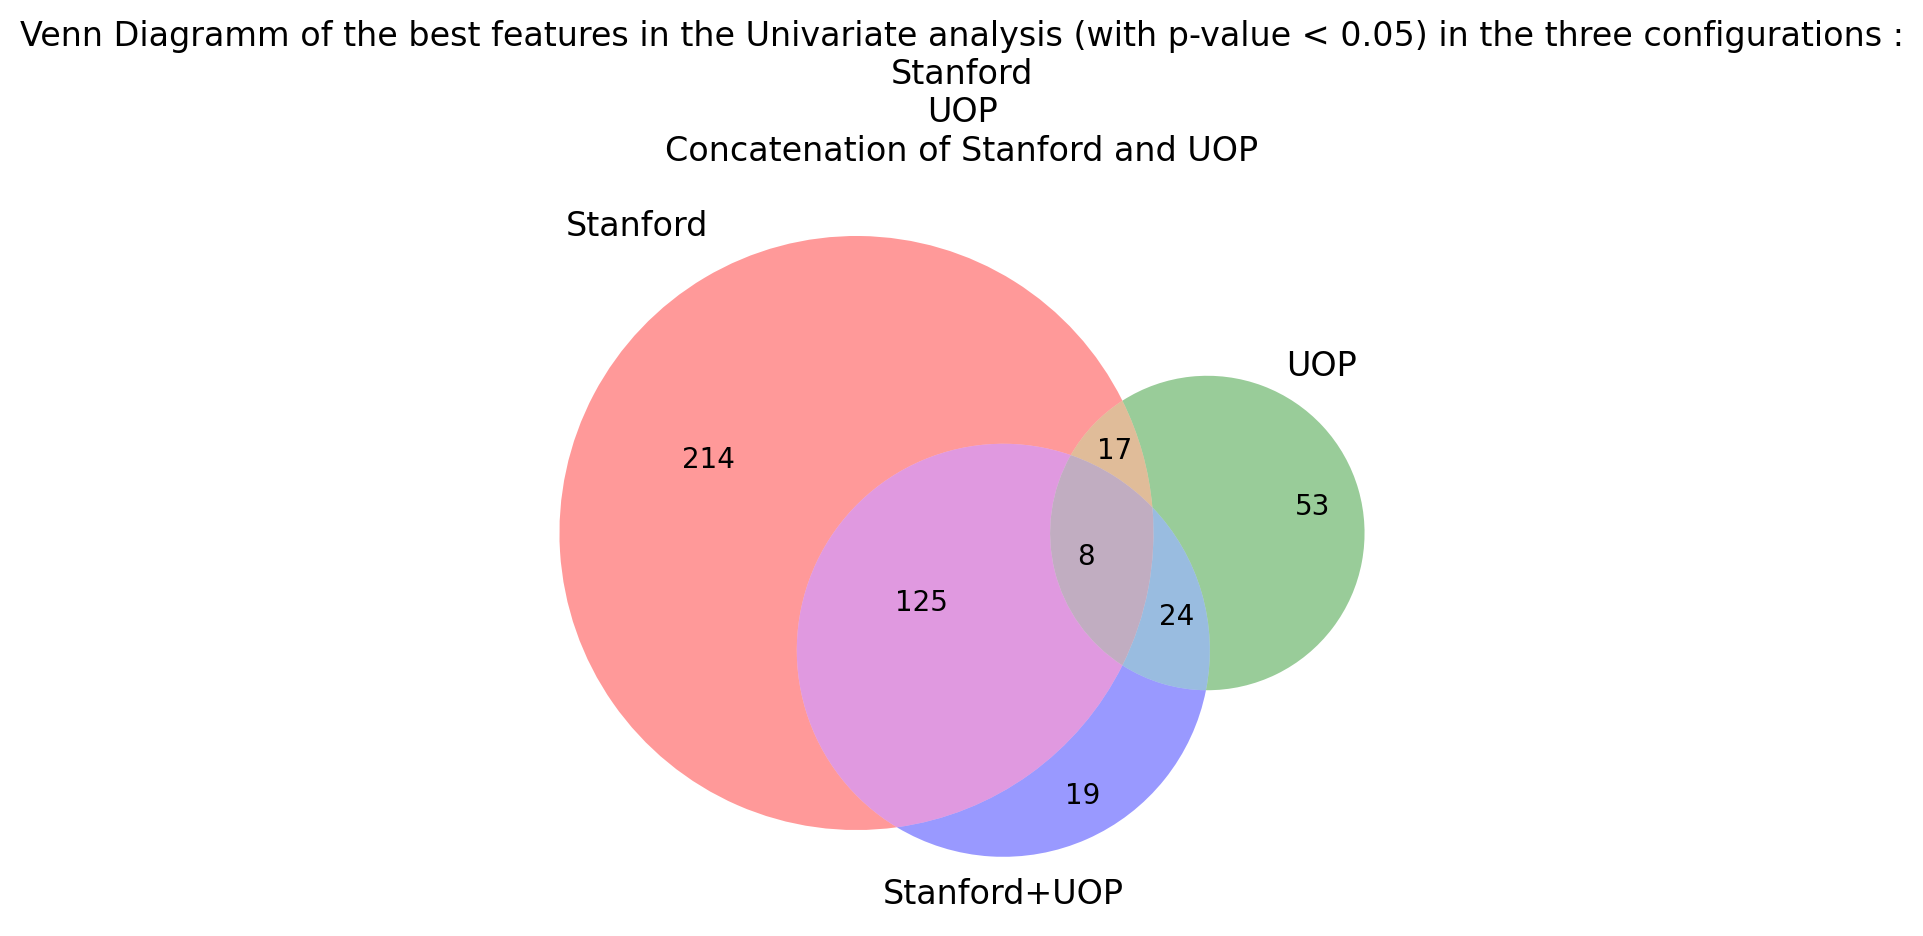

In [67]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

threshold = 5e-2

top_features_val = pd.read_csv('./Univariate/mean without Zscoring/Stanford/global/Mann-WhitneyU-testPval.csv', index_col=0)
top_features_UOP = pd.read_csv('./Univariate/mean without Zscoring/UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)
top_features_global = pd.read_csv('./Univariate/mean without Zscoring/Stanford+UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)

top_features_val = set(top_features_val[top_features_val["p-value"] < threshold].index)
top_features_UOP = set(top_features_UOP[top_features_UOP["p-value"] < threshold].index)
top_features_global = set(top_features_global[top_features_global["p-value"] < threshold].index)

# Make the diagram
venn3([top_features_val, top_features_UOP, top_features_global],
      ('Stanford','UOP','Stanford+UOP'))
plt.title("Venn Diagramm of the best features in the Univariate analysis (with p-value < 0.05) in the three configurations :\nStanford\nUOP\nConcatenation of Stanford and UOP")
plt.show()

## Median

In [68]:
global_data_median = pd.concat([X_Celldensities_median, X_Function_median, X_Metavariables_median, X_Neighborhood_median], axis=1)
global_outcome = y['grade'] - 1 # instead of 1-2 -> 0-1 for the grade

In [69]:
univariate_analysis(data_median, 'Stanford+UOP', value_type='median without Zscoring')
univariate_analysis(val_data_median, 'Stanford', value_type='median without Zscoring')
univariate_analysis(UOP_data_median, 'UOP', value_type='median without Zscoring')

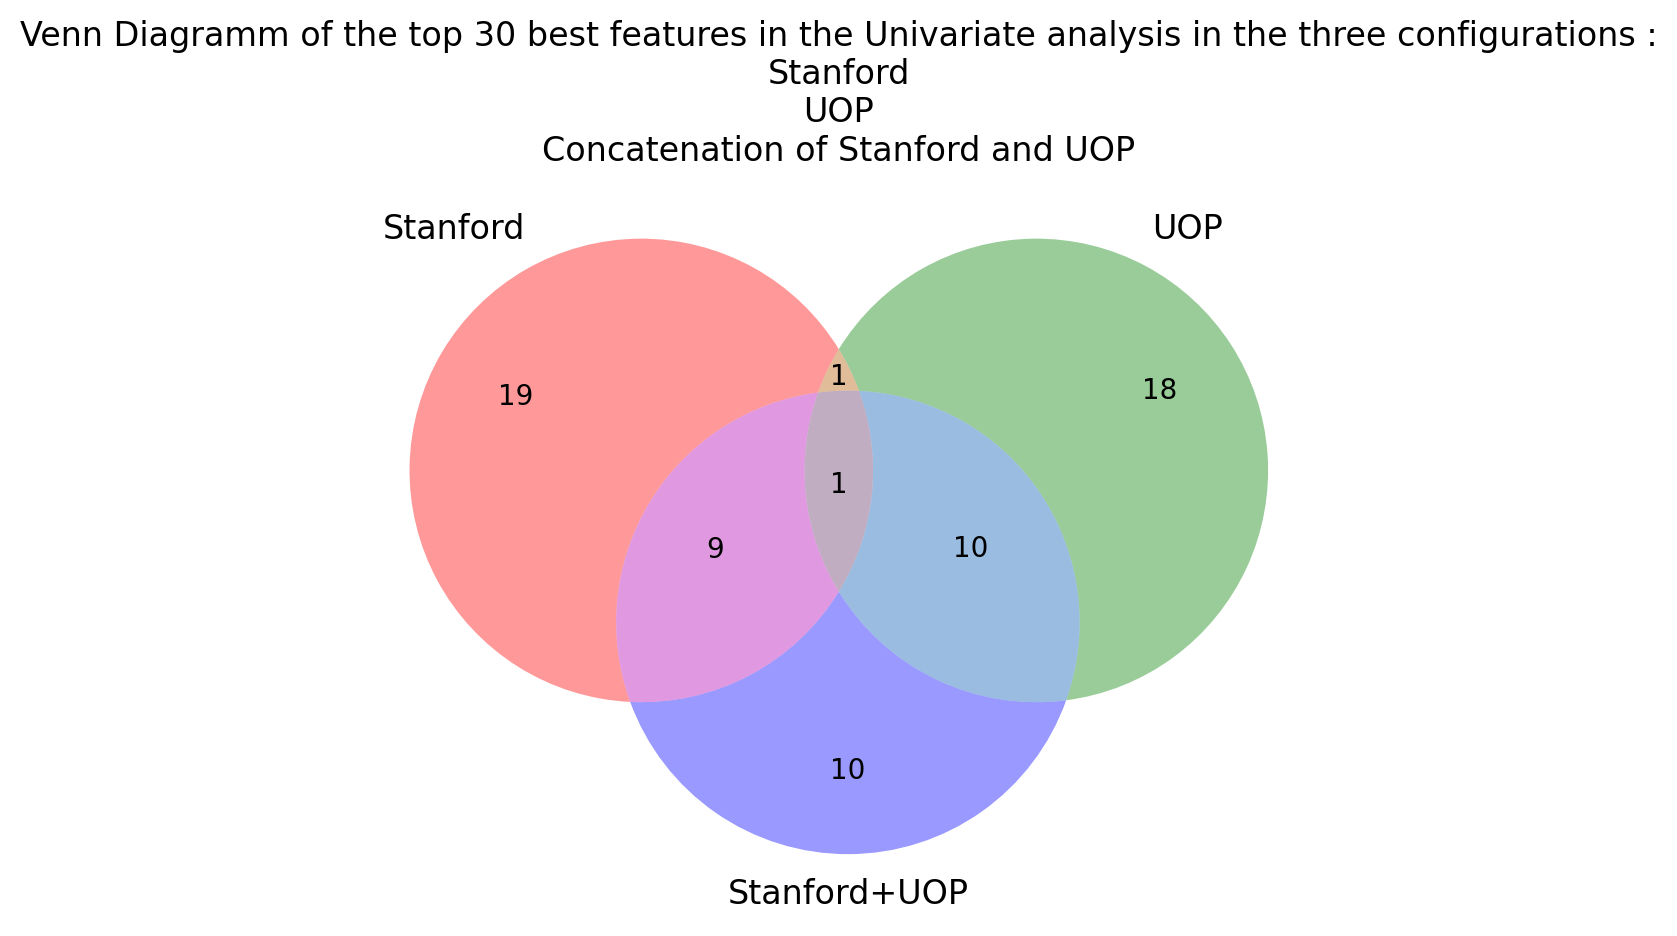

In [70]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
top_features_val = set(pd.read_csv('./Univariate/median without Zscoring/Stanford/global/Mann-WhitneyU-testPval.csv', index_col=0)[:30].index)
top_features_UOP = set(pd.read_csv('./Univariate/median without Zscoring/UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)[:30].index)
top_features_global = set(pd.read_csv('./Univariate/median without Zscoring/Stanford+UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)[:30].index)


# Make the diagram
venn3([top_features_val, top_features_UOP, top_features_global],
      ('Stanford','UOP','Stanford+UOP'))
plt.title("Venn Diagramm of the top 30 best features in the Univariate analysis in the three configurations :\nStanford\nUOP\nConcatenation of Stanford and UOP")
plt.show()

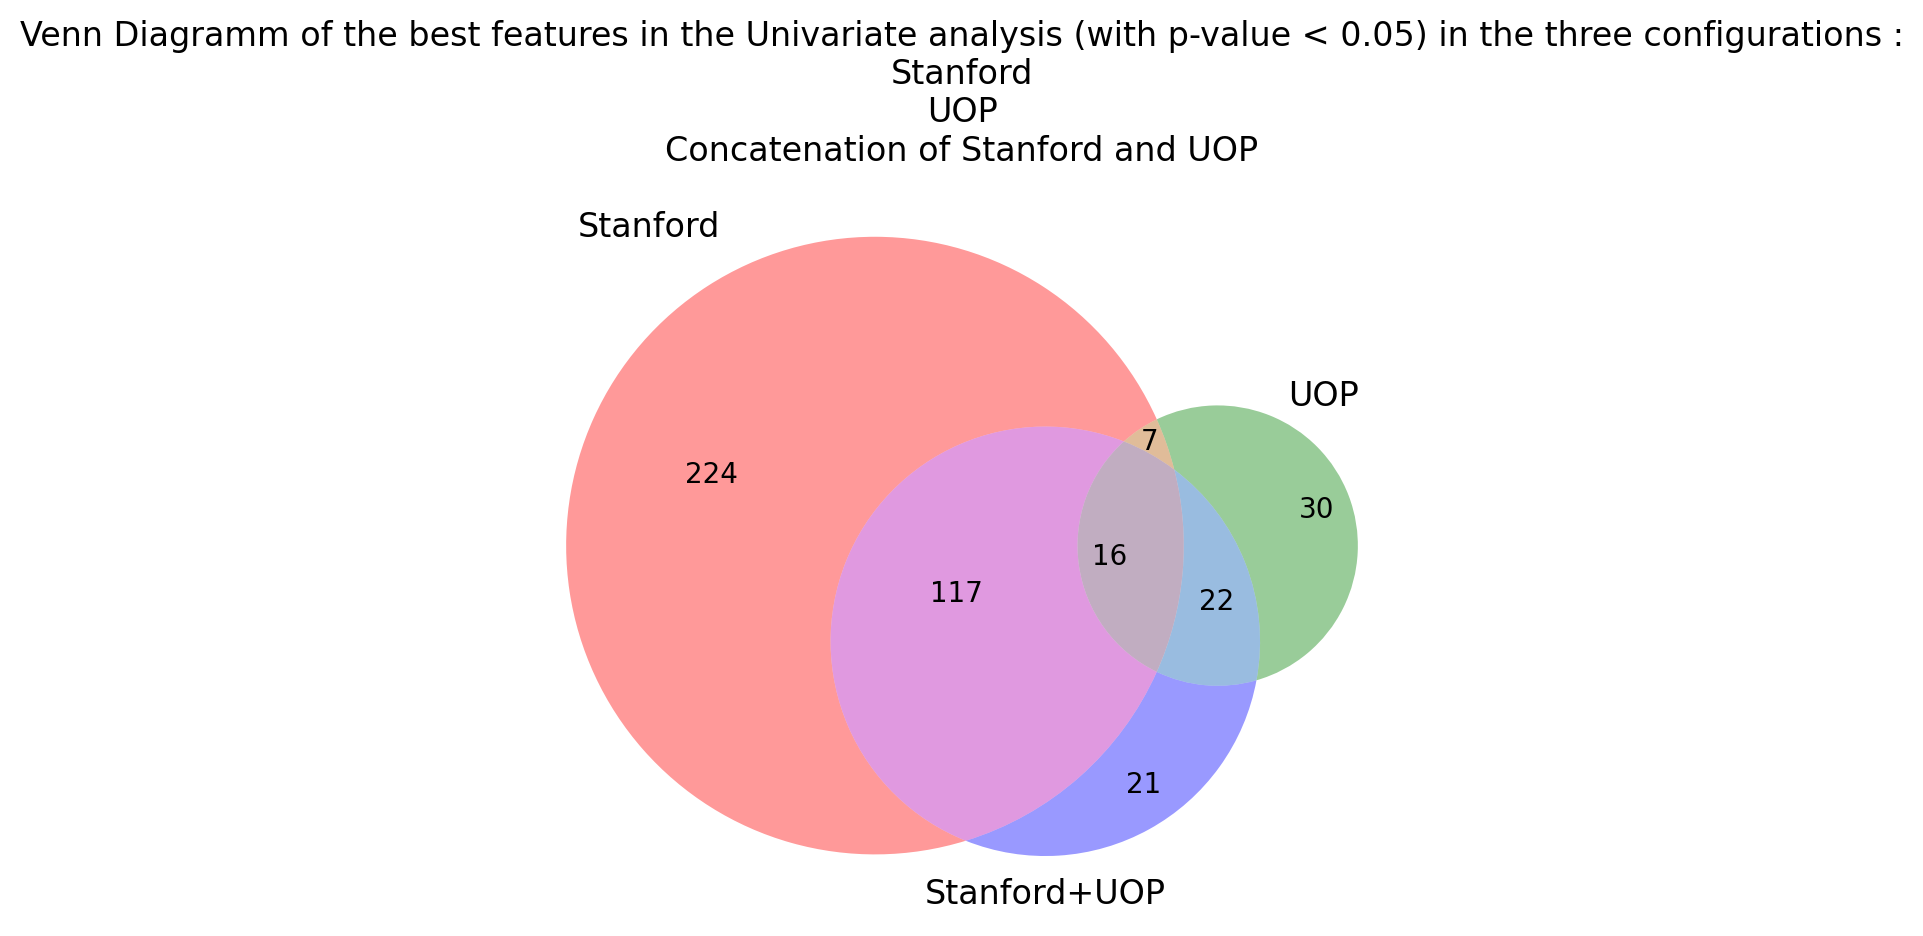

In [71]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

threshold = 5e-2

top_features_val = pd.read_csv('./Univariate/median without Zscoring/Stanford/global/Mann-WhitneyU-testPval.csv', index_col=0)
top_features_UOP = pd.read_csv('./Univariate/median without Zscoring/UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)
top_features_global = pd.read_csv('./Univariate/median without Zscoring/Stanford+UOP/global/Mann-WhitneyU-testPval.csv', index_col=0)

top_features_val = set(top_features_val[top_features_val["p-value"] < threshold].index)
top_features_UOP = set(top_features_UOP[top_features_UOP["p-value"] < threshold].index)
top_features_global = set(top_features_global[top_features_global["p-value"] < threshold].index)

# Make the diagram
venn3([top_features_val, top_features_UOP, top_features_global],
      ('Stanford','UOP','Stanford+UOP'))
plt.title("Venn Diagramm of the best features in the Univariate analysis (with p-value < 0.05) in the three configurations :\nStanford\nUOP\nConcatenation of Stanford and UOP")
plt.show()

# Results folder

In [14]:
# result_folder = "./RS_MC_RP"

# Main script

In [17]:
# for omic_name, X_omic in data.items():
#     X_omic = remove_low_info_samples(X_omic)
#     data[omic_name] = X_omic

Celldensities
Function
Metavariables
Neighborhood
Outcome


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
stabl = Stabl(
    lambda_name='C',
    lambda_grid=np.linspace(0.01, 5, 10),
    n_bootstraps=1000,
    artificial_type="random_permutation",
    artificial_proportion=1.,
    replace=False,
    fdr_threshold_range=np.arange(0.2, 1, 0.01),
    sample_fraction=.5,
    random_state=42
 )

outer_splitter = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=1)

stability_selection = clone(stabl).set_params(artificial_type=None, hard_threshold=0.5)

# Multi-omic Training-CV

In [ ]:
#np.random.seed(111)

In [ ]:
predictions_dict = multi_omic_stabl_cv(
    data_dict=data,
    y=global_outcome,
    outer_splitter=outer_splitter,
    stabl=stabl,
    stability_selection=stability_selection,
    task_type="binary",
    save_path="../Tumor Study/Results"
)

# Multiomic Training to derive coefficients

In [ ]:
# np.random.seed(111)

In [ ]:
stabl_multi = Stabl(
    lambda_grid=np.linspace(0.01, 5, 30),
    n_bootstraps=5000,
    artificial_proportion=1.,
    artificial_type="random_permutation",
    hard_threshold=None,
    replace=False,
    fdr_threshold_range=np.arange(0.2, 1, 0.01),
    sample_fraction=.7,
    random_state=111
)

stability_selection = clone(stabl_multi).set_params(artificial_type=None, hard_threshold=.3)

In [ ]:
predictions_dict = multi_omic_stabl(
    data_dict=train_data_dict,
    y=train_outcome,
    stabl=stabl_multi,
    stability_selection=stability_selection,
    task_type="binary",
    save_path=Path(result_folder),
    X_test=pd.concat(test_data_dict.values(),axis=1),
    y_test=test_outcome
)

# Late fusion lasso

In [ ]:
# late_fusion_lasso_cv(
#     train_data_dict=train_data_dict,
#     y=train_outcome,
#     outer_splitter=outer_splitter,
#     task_type="binary",
#     save_path=result_folder,
#     groups=None
# )

# Features Table

In [ ]:
selected_features_dict = dict()
for model in ["STABL", "EF Lasso", "SS 03", "SS 05", "SS 08"]:
    path = Path(result_folder, "Training-Validation", f"{model} coefficients.csv")
    try:
        selected_features_dict[model] = list(pd.read_csv(path, index_col=0).iloc[:, 0].index)
    except:
        selected_features_dict[model] = []

In [ ]:
features_table = compute_features_table(
    selected_features_dict,
    X_train=pd.concat(train_data_dict.values(), axis=1),
    y_train=train_outcome,
    task_type="binary"
)

In [97]:
features_table.to_csv(Path(result_folder, "Training-Validation", "Table of features.csv"))

NameError: name 'features_table' is not defined